# import lib

In [79]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc,roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import seaborn as sns

# Dataset path

In [4]:
IMAGE_SIZE = [224, 224]

train_path = 'dataset/Train'
val_path = 'dataset/Val'
test_path = 'dataset/Test'

#  Data augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

Found 3641 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


# Model

In [ ]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False
                  
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output  
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

model.compile(
loss = 'categorical_crossentropy',
optimizer = 'adam',
metrics = ['accuracy']
)

with tf.device('/GPU:0'):
    history = model.fit(
        training_set,
        epochs=5,
        verbose=1,
        validation_data=val_set
    )


# Model testing

In [16]:
print("Evaluate on test data")
results = model.evaluate(test_set, batch_size=32)
print("Test loss, Test accuracy: ", results)

model.save('model.h5')

Evaluate on test data
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9934 - loss: 0.0204


Test loss, Test accuracy:  [0.022208359092473984, 0.9912087917327881]


# Loss Curve,Accuracy Curve

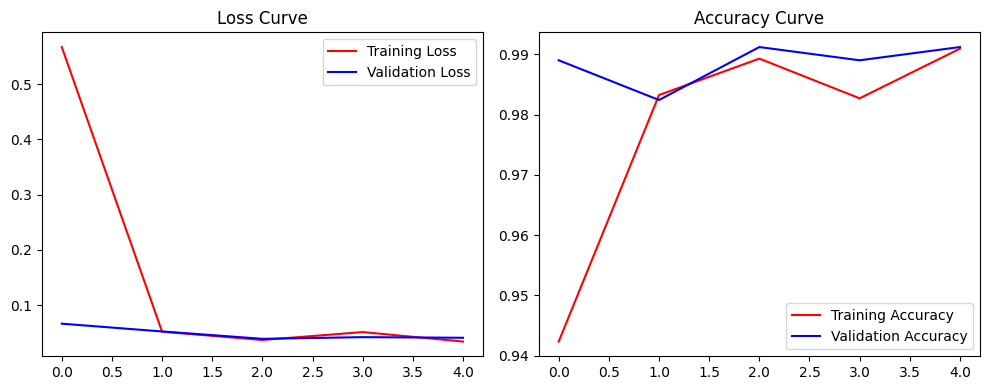

In [18]:
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", label="Training Loss")
    axes[0].plot(history["val_loss"], "b-", label="Validation Loss")
    axes[0].set_title("Loss Curve")
    axes[0].legend()

    axes[1].plot(history["accuracy"], "r-", label="Training Accuracy")
    axes[1].plot(history["val_accuracy"], "b-", label="Validation Accuracy")
    axes[1].set_title("Accuracy Curve")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot(history.history)

# Predection 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


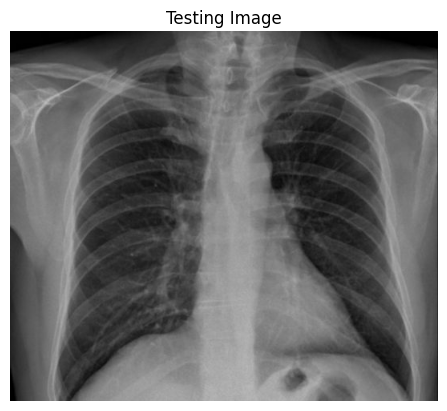

The person is affected by COVID-19


In [68]:
from tensorflow.keras.preprocessing import image

img_path = r"E:\Major projects need\Covid\dataset\COVID-19 (1265).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

mymodel = load_model('model.h5')
classes = mymodel.predict(x)
result = np.argmax(classes)

plt.imshow(plt.imread(img_path))
plt.title("Testing Image")
plt.axis('off')
plt.show()

if result == 1:
    print("The person is affected by COVID-19")
else:
    print("The result is normal")

# confusion matrix

Found 455 images belonging to 2 classes.


E:\python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
Confusion Matrix:
 [[127   1]
 [  0 327]]


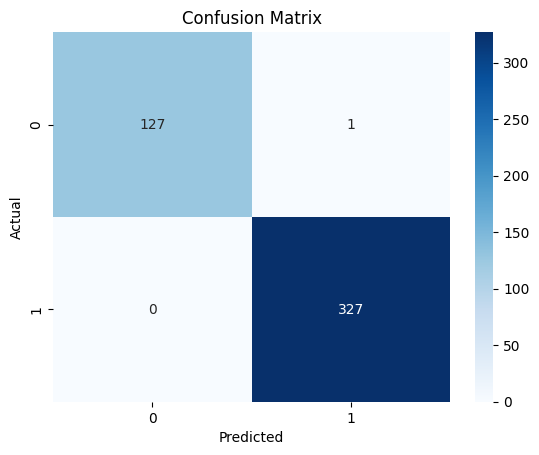

In [43]:
test_set = train_datagen.flow_from_directory(
    'dataset/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

y_pred = np.argmax(mymodel.predict(test_set), axis=1)
y_test = test_set.classes

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# classification report

In [81]:
print(classification_report(y_test, y_pred, target_names=['COVID-19', 'Normal']))

              precision    recall  f1-score   support

    COVID-19       1.00      0.99      1.00       128
      Normal       1.00      1.00      1.00       327

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455



# ROC and AUC 

ROC AUC score: 0.99609375


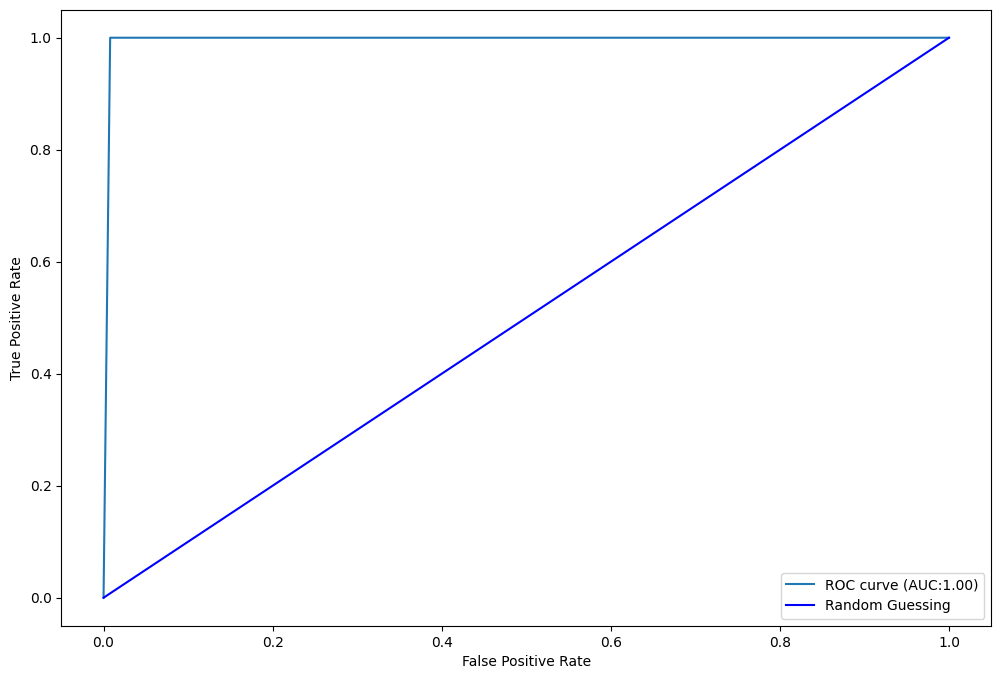

In [80]:
target= ['ROC curve']
fig, c_ax = plt.subplots (1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    for (idx, c_label) in enumerate (target):
        fpr, tpr, thresholds = roc_curve (y_test[:, idx].astype (int), y_pred[:,idx]) 
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc (fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()